# Assignment 1

### - KNN으로 HyperParameter 이해하기

# Load Dataset

#### Import packages

In [1]:
# data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.plotting import parallel_coordinates

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

#### Load iris data 

In [2]:
from sklearn.datasets import load_iris
# sklearn에 내장되어있는 iris 데이터를 사용

In [3]:
iris = load_iris()

In [4]:
print(iris.DESCR)
# iris dataset 정보를 알 수 있다

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

- feature에는 sepal length, sepal width, petal length, petal width가 있다.
- target은 3개의 class가 있으며 각각 Iris-Setosa, Iris-Versicolour, Iris-Virginica, 즉, 붖꽃의 종류이다.
- Setosa, Versicolour, Virginica가 각각 0, 1, 2로 분류 되어있다.
- 총 150개의 instance가 존재한다.

#### Make DataFrame

In [5]:
# feature와 target를 하나의 DataFrame으로 만들고 각각의 column명을 붙여주었다.
df = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.Series(iris.target, dtype="category")
y = y.cat.rename_categories(iris.target_names)
df['species'] = y

In [6]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# EDA

In [7]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
df.groupby('species').size()

species
setosa        50
versicolor    50
virginica     50
dtype: int64

- 각 Class 별로 data가 50개씩 존재한다.

#### Pairplot

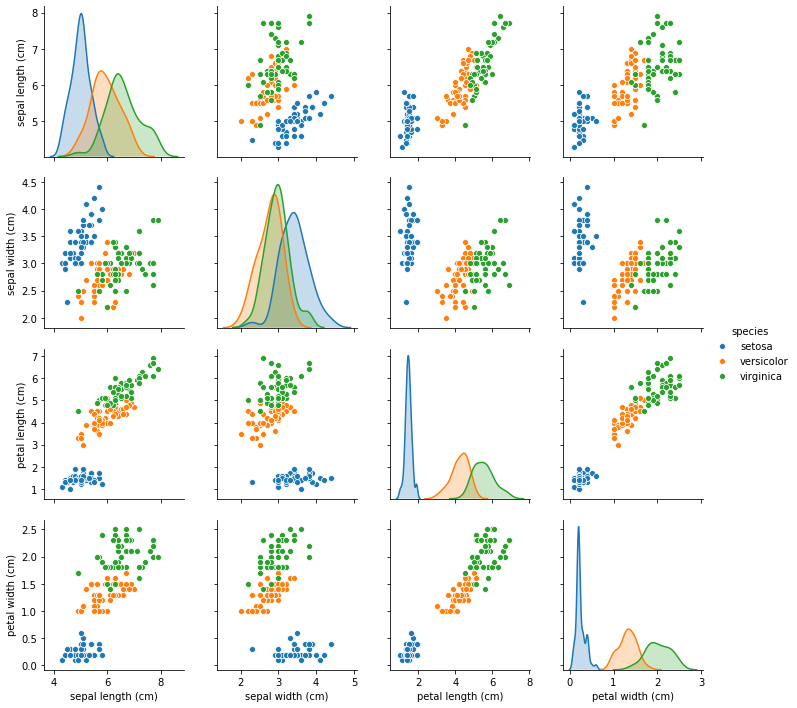

In [9]:
sns.pairplot(df, hue="species")
plt.show()

- petal length 만으로 0과 1종을 완전히 구분할 수 있다
- petal length와 petal width 두가지로 나누면 1과 2종도 구분해 낼 수 있을 것으로 보인다

#### Distplot

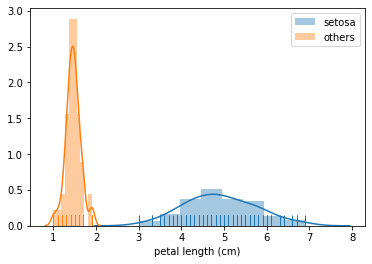

In [10]:
sns.distplot(df[df.species != "setosa"]["petal length (cm)"], hist=True, rug=True, label="setosa")
sns.distplot(df[df.species == "setosa"]["petal length (cm)"], hist=True, rug=True, label="others")
plt.legend()
plt.show()

- 위의 분포를 보면 petal length 하나의 변수만으로 setosa와 다른 종들을 쉽게 분류해낼 수 있을 것으로 보인다.

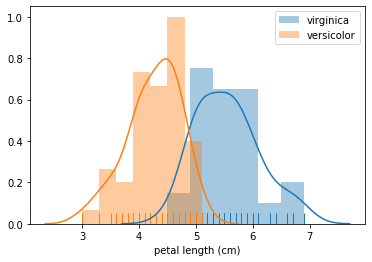

In [11]:
sns.distplot(df[df.species == "virginica"]["petal length (cm)"], hist=True, rug=True, label="virginica")
sns.distplot(df[df.species == "versicolor"]["petal length (cm)"], hist=True, rug=True, label="versicolor")
plt.legend()
plt.show()

- 반면 virginica와 versicolor는 petal length 만으로는 완전히 분류해내기 어려워보인다. 

#### Parallel coordinates plot

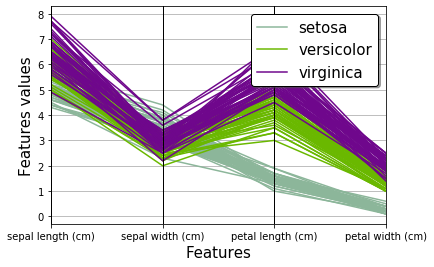

In [12]:
parallel_coordinates(df, "species")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features values', fontsize=15)
plt.legend(loc=1, prop={'size': 15}, frameon=True, shadow=True, facecolor="white", edgecolor="black")
plt.show()

- 각 feature들로 얼마나 붓꽃 종류를 구분할 수 있는지 한눈에 알 수 있다.
- 앞에서 언급했듯이 petal length와 petal width로 0과 1를 구분해낼 수 있다

#### Boxplot

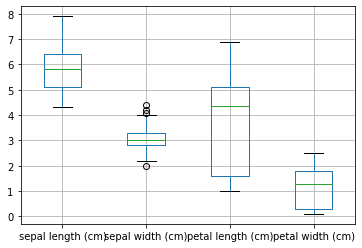

In [13]:
df.boxplot()
plt.show()

- 각 데이터의 분포를 살펴보았다.
- sepal_width 데이터에서 outlier가 있는 것을 알 수 있었다.

# Preprocessing

- KNN을 사용하기에 앞서 거리를 구하는 것이 분류의 핵심이므로 Scaling을 해주기로 하였다.
- 그 전에 train data와 test data를 나누어 주기로 하였다.

#### Split data

In [14]:
# train과 test data를 0.75 : 0.25 비율로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=3)

#### Scaling

In [15]:
# Standard Scaler
ss = StandardScaler() # Scaling
X_train_s = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)
X_test_s = pd.DataFrame(ss.fit_transform(X_test), columns = X_test.columns)
X_train_s.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.701282,-0.855303,0.852152,0.903021
1,0.444603,-2.029248,0.390247,0.368604
2,0.701282,-0.620514,1.025366,1.170229
3,-0.068753,-0.855303,0.043819,-0.032208
4,-1.608823,1.257798,-1.630584,-1.368249


In [16]:
# Minmax Scaler
ms = MinMaxScaler()
X_train_m = pd.DataFrame(ms.fit_transform(X_train), columns = X_train.columns)
X_test_m = pd.DataFrame(ms.fit_transform(X_test), columns = X_test.columns)
X_train_m.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.583333,0.318182,0.754386,0.750000
1,0.527778,0.090909,0.614035,0.583333
2,0.583333,0.363636,0.807018,0.833333
3,0.416667,0.318182,0.508772,0.458333
4,0.083333,0.727273,0.000000,0.041667


# Modeling

#### Print metrics function

In [17]:
def print_metrics(model, X_train):
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print('*** Cross val score *** \n   {}'.format(scores))
    print('\n*** Mean Accuracy *** \n   {:.7f}'.format(scores.mean()))
    # print('\n*** Confusion Matrix *** \n', confusion_matrix(y_train, model.predict(X_train)))

- 한번에 validation용 metrics를 출력할 수 있는 함수를 생성하였다.

#### Simple Model

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print_metrics(knn, X_train)

*** Cross val score *** 
   [0.91666667 1.         0.91666667 1.         1.         1.
 1.         1.         1.         0.88888889]

*** Mean Accuracy *** 
   0.9722222


#### Standard Scaled Model

In [19]:
knn_s = KNeighborsClassifier()
knn_s.fit(X_train_s, y_train)
print_metrics(knn_s, X_train_s)

*** Cross val score *** 
   [0.83333333 1.         0.91666667 1.         0.91666667 1.
 1.         0.90909091 0.8        0.88888889]

*** Mean Accuracy *** 
   0.9264646


#### MinMax Scaled Model

In [20]:
knn_m = KNeighborsClassifier()
knn_m.fit(X_train_m, y_train)
print_metrics(knn_m, X_train_m)

*** Cross val score *** 
   [0.83333333 1.         0.91666667 1.         0.91666667 1.
 1.         1.         0.9        0.88888889]

*** Mean Accuracy *** 
   0.9455556


# Hyperparameter Tuning

#### Parameters  
- **n_neighbors**: 검색할 이웃의 수로 default 값은 5이다.
- **Metric**: 거리 측정 방식을 변경하는 매개변수로 default 값은 minkowsi이다
- **Weights**: 예측에 사용하는 가중치로 uniform 은 각 이웃에 동일한 가중치를 , ‘distance’는 가까운 이웃이 멀리 있는 이웃보다 더욱 큰 영향을 미친다.

#### Grid Search CV

In [21]:
grid_params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

##### 1. No Scaled

In [22]:
gs = GridSearchCV(knn, grid_params, cv=10)
gs.fit(X_train, y_train)
print("Best Parameters : ", gs.best_params_)
print("Best Score : ", gs.best_score_)
print("Best Test Score : ", gs.score(X_test, y_test))

Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Score :  0.9732142857142857
Best Test Score :  0.9473684210526315


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


##### 2. Standard Scaled

In [23]:
gs_s = GridSearchCV(knn_s, grid_params, cv=10)
gs_s.fit(X_train_s, y_train)
print("Best Parameters : ", gs_s.best_params_)
print("Best Score : ", gs_s.best_score_)
print("Best Test Score : ", gs_s.score(X_test_s, y_test))

Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'distance'}
Best Score :  0.9732142857142857
Best Test Score :  0.9473684210526315


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


##### 3. MinMax Scaled

In [24]:
gs_m = GridSearchCV(knn_m, grid_params, cv=10)
gs_m.fit(X_train_m, y_train)
print("Best Parameters : ", gs_m.best_params_)
print("Best Score : ", gs_m.best_score_)
print("Best Test Score : ", gs_m.score(X_test_m, y_test))

Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best Score :  0.9732142857142857
Best Test Score :  0.9736842105263158


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


- Score의 결과가 가장 좋은 MinMax Scaled Data의 {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'} parameters를 선택하기로 하였다.

#### Final Model

In [25]:
knn_m = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 9, weights = 'uniform')
knn_m.fit(X_train_m, y_train)
print_metrics(knn_m, X_train_m)

*** Cross val score *** 
   [0.91666667 1.         1.         1.         0.91666667 1.
 1.         1.         1.         0.88888889]

*** Mean Accuracy *** 
   0.9722222


# Evaluation

In [26]:
def print_test_metrics(model, X_test):
    print('*** Test Accuracy *** \n   {}'.format(model.score(X_test, y_test)))
    print('\n*** Confusion Matrix *** \n', confusion_matrix(y_test, model.predict(X_test)))

In [27]:
print_test_metrics(knn_m, X_test_m)

*** Test Accuracy *** 
   0.9736842105263158

*** Confusion Matrix *** 
 [[15  0  0]
 [ 0 11  1]
 [ 0  0 11]]
